**Machine Learning for Time Series (Master MVA)**

- TP5, Friday 4<sup>th</sup> March 2022
- [Link to the class material.](http://www.laurentoudre.fr/ast.html)

# Introduction

In this notebook, we illustrate the following concept:
- change point detection.

## Setup

In [ ]:
%%capture
!pip install ruptures loadmydata

**Import**

In [ ]:
import datetime as dt
from math import log

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ruptures as rpt
from loadmydata.load_uea_ucr import load_uea_ucr_data
from matplotlib.dates import DateFormatter
from ruptures.base import BaseCost
from ruptures.metrics import hausdorff
from scipy.stats import ttest_ind
from scipy.optimize import minimize

**Utility functions**

In [ ]:
def fig_ax(nrows=1, figsize=(15, 3)):
    return plt.subplots(nrows=nrows, figsize=(figsize[0], figsize[1] * nrows))

In [ ]:
myFmt = DateFormatter("%H:%M")

def plot_clinear_approx(time_index, signal, bkps, ax=None):
    # plot
    ax.plot(time_index, signal)
    # plot changes
    for b in bkps[:-1]:
        ax.axvline(time_index[b], ls="--", color="k")
    # add linear approximation
    indexes = np.r_[0, np.array(bkps) - 1]
    ax.plot(
        np.take(time_index, indexes),
        np.take(signal, indexes),
        color="k",
        alpha=0.5,
    )
    ax.scatter(
        np.take(time_index, indexes),
        np.take(signal, indexes),
        color="r",
        alpha=0.5,
        s=100,
        marker="*",
    )
    ax.margins(x=0)
    ax.xaxis.set_major_formatter(myFmt)

# Change point detection

Change point detection consists in finding the temporal boundaries of homogeneous portions of a signal.

## Mean shift detection

The simplest (and oldest) change point detection methods deals with mean shifts.

### Single change point

We start by trying to detect a single shift in mean (in a synthetic signal).

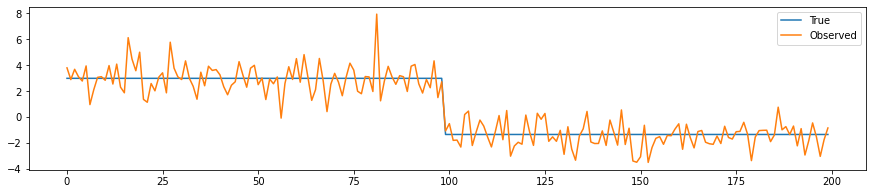

In [ ]:
# generate signal
n_samples = 200
n_bkps = 1
n_dims = 1
sigma_noise = 1
signal, bkps = rpt.pw_constant(
    n_samples=n_samples, n_features=n_dims, n_bkps=n_bkps, noise_std=0
)
signal_with_noise = signal + np.random.normal(
    scale=sigma_noise, size=signal.shape
)

fig, ax = fig_ax()
ax.plot(signal, label="True")
ax.plot(signal_with_noise, label="Observed")
_ = plt.legend()

We fit the noisy signal with a piecewise constant function with a single discontinuity. The best fit is the function which minimizes the norm of the residuals.

For a $T$-sample signal $y$ and an index $a$, this amounts to:

$$
\sum_{t< a} \|y_t-\bar{y}_{0..a}\|^2 + \sum_{t\geq a} \|y_t-\bar{y}_{a..T}\|^2
$$

where $\bar{y}_{\text{left}}$ and $\bar{y}_{\text{right}}$ are the empirical means of $\{y_0,\dots,y_{a-1}\}$ and $\{y_a,\dots,y_{T-1}\}$ respectively.

The detection procedure consists in finding the index $a$ that minimizes this sum of costs.

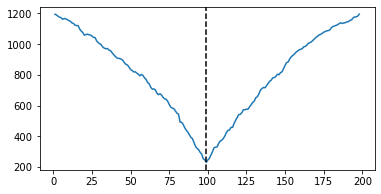

In [ ]:
sum_of_cost_list = list()

admissible_change_points = np.arange(1, n_samples - 1)

for mid_point in admissible_change_points:
    sum_of_cost = signal_with_noise[
        :mid_point
    ].var() * mid_point + signal_with_noise[mid_point:].var() * (
        n_samples - mid_point
    )
    sum_of_cost_list.append(sum_of_cost)

fig, ax = fig_ax(figsize=(6, 3))
ax.plot(admissible_change_points, sum_of_cost_list)

# take the minimum sum of costs
detected_change_point = admissible_change_points[np.argmin(sum_of_cost_list)]

# add a vertical dashed line
ax.axvline(detected_change_point, ls="--", color="k")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What happens to the sum of costs when the noise varies?</p>
    <p>And when the number of samples increases?</p>
</div>

To check if a change point is indeed present, let us do a t-test between the left part of the signal and the right part of the signal.

In [ ]:
ttest_ind(
    signal_with_noise[:detected_change_point],
    signal_with_noise[detected_change_point:],
)

Ttest_indResult(statistic=array([28.99557432]), pvalue=array([3.41986431e-73]))

At first sight, the detected change seems to be statistically significant.

However, let us test this procedure on a pure noise signal.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Perform the same procedure as before on the pure noise signal. According to the t-test, is there a change point?</p>
    <p>What went wrong?</p>
</div>

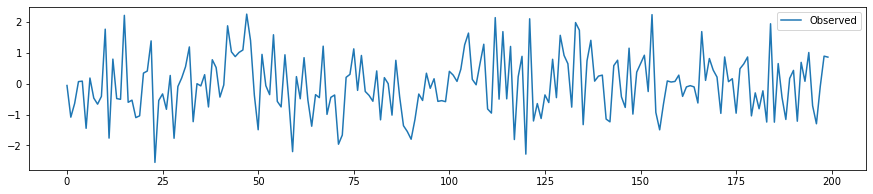

In [ ]:
# generate signal
n_samples = 200
n_bkps = 1
n_dims = 1
sigma_noise = 1
signal, bkps = rpt.pw_constant(
    n_samples=n_samples, n_features=n_dims, n_bkps=n_bkps, noise_std=0
)
pure_noise = np.random.normal(
    scale=sigma_noise, size=signal.shape
)

fig, ax = fig_ax()
ax.plot(pure_noise, label="Observed")
_ = plt.legend()

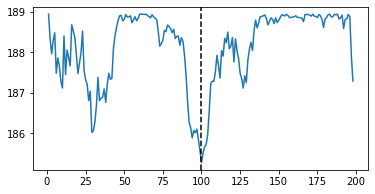

In [ ]:
sum_of_cost_list = list()

admissible_change_points = np.arange(1, n_samples - 1)

for mid_point in admissible_change_points:
    sum_of_cost = pure_noise[
        :mid_point
    ].var() * mid_point + pure_noise[mid_point:].var() * (
        n_samples - mid_point
    )
    sum_of_cost_list.append(sum_of_cost)

fig, ax = fig_ax(figsize=(6, 3))
ax.plot(admissible_change_points, sum_of_cost_list)

# take the minimum sum of costs
detected_change_point = admissible_change_points[np.argmin(sum_of_cost_list)]

# add a vertical dashed line
ax.axvline(detected_change_point, ls="--", color="k")

In [ ]:
ttest_ind(
    pure_noise[:detected_change_point],
    pure_noise[detected_change_point:],
)

Ttest_indResult(statistic=array([-1.97659073]), pvalue=array([0.04947616]))

We will introduce later a criterion to assess the presence of a change.

### Multiple change points (known $K$)

To extend the detection to more than one change, we simply some the costs of each segment defined by the $K$ change points $t_1,\dots,t_K$:

$$
\sum_{t=0}^{t_1-1} \|y_t-\bar{y}_{0..t_1}\|^2 + \sum_{t=t_1}^{t_2-1} \|y_t-\bar{y}_{t_1..t_2}\|^2 + \dots + \sum_{t=t_K}^{T-1} \|y_t-\bar{y}_{t_K..T}\|^2.
$$

We minimize over the $t_k$, using dynamic programming. (Other methods exists, e.g. binary segmentation, bottom-up, window-based, but are only approximate.)

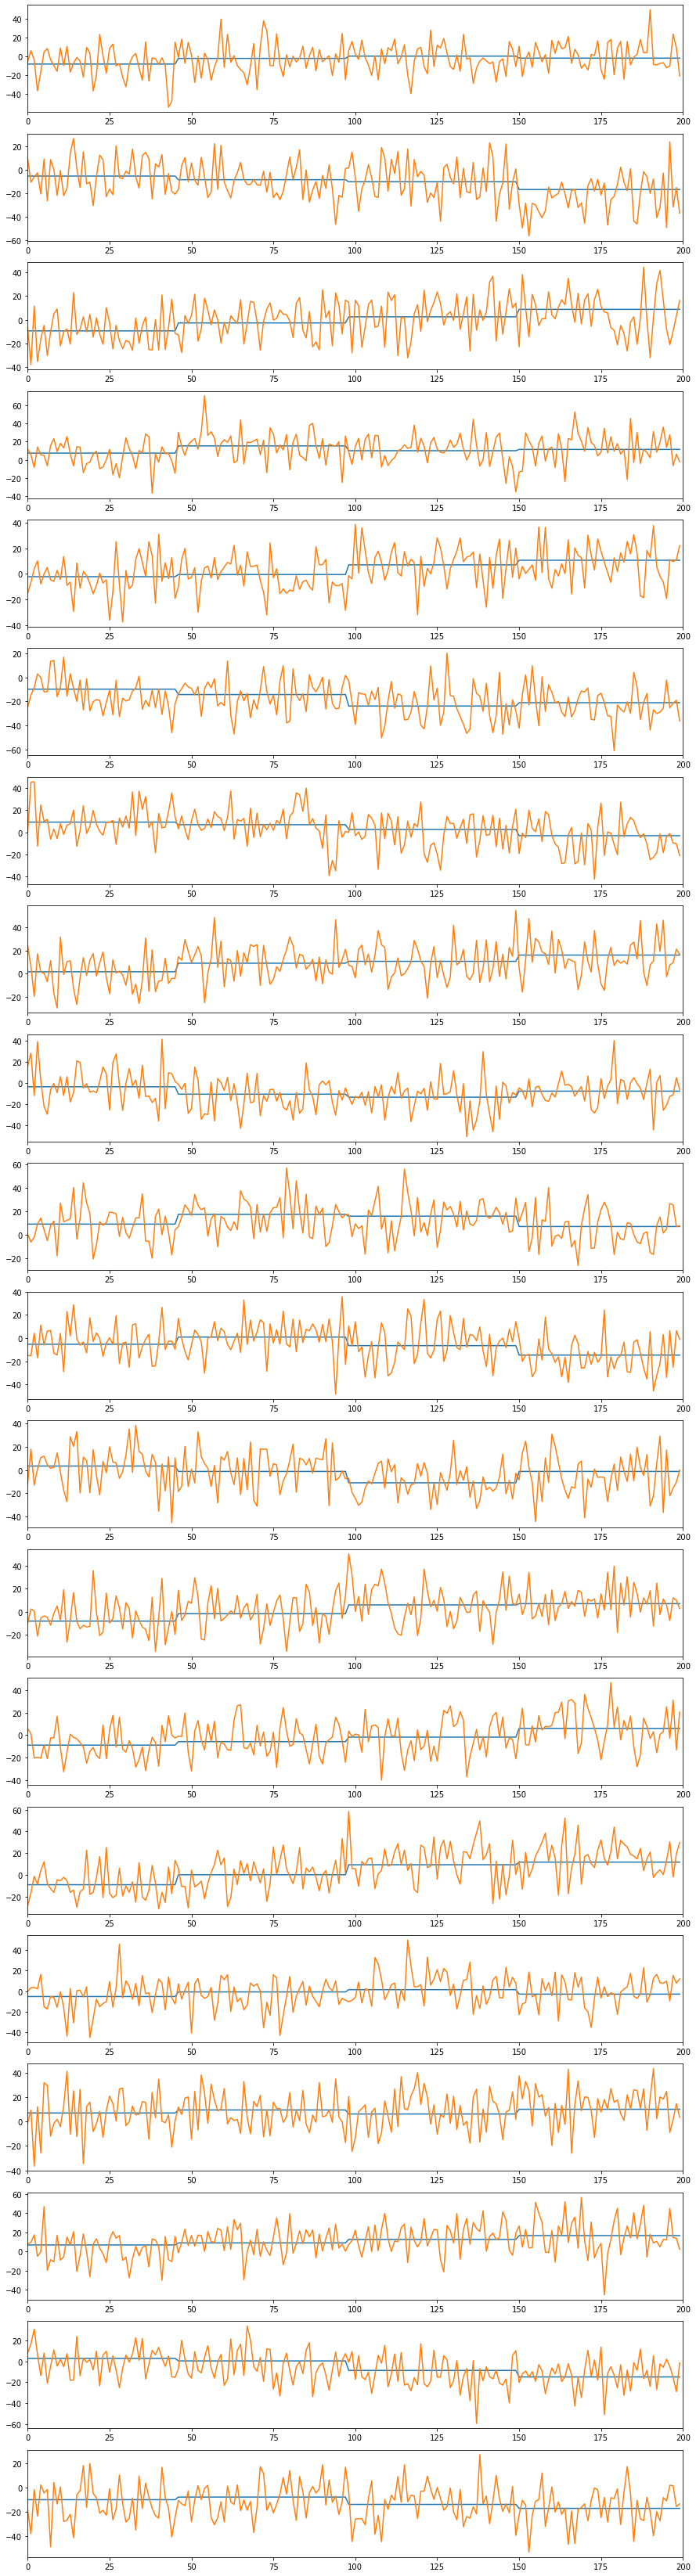

In [ ]:
# generate signal
n_samples = 200
n_bkps = 3
n_dims = 20
sigma_noise = 15
signal, bkps = rpt.pw_constant(
    n_samples=n_samples, n_features=n_dims, n_bkps=n_bkps, noise_std=0
)
signal_with_noise = signal + np.random.normal(
    scale=sigma_noise, size=signal.shape
)

# display
fig, ax_arr = fig_ax(nrows=n_dims)
for (signal1d, signal1d_with_noise, ax) in zip(
    signal.T, signal_with_noise.T, ax_arr
):
    ax.plot(signal1d)
    ax.plot(signal1d_with_noise)
    ax.set_xlim(0, n_samples)

Perform change point detection using dynamic programming.

In [ ]:
algo = rpt.Dynp(model="l2", jump=1).fit(signal_with_noise)

error: 4.0 samples


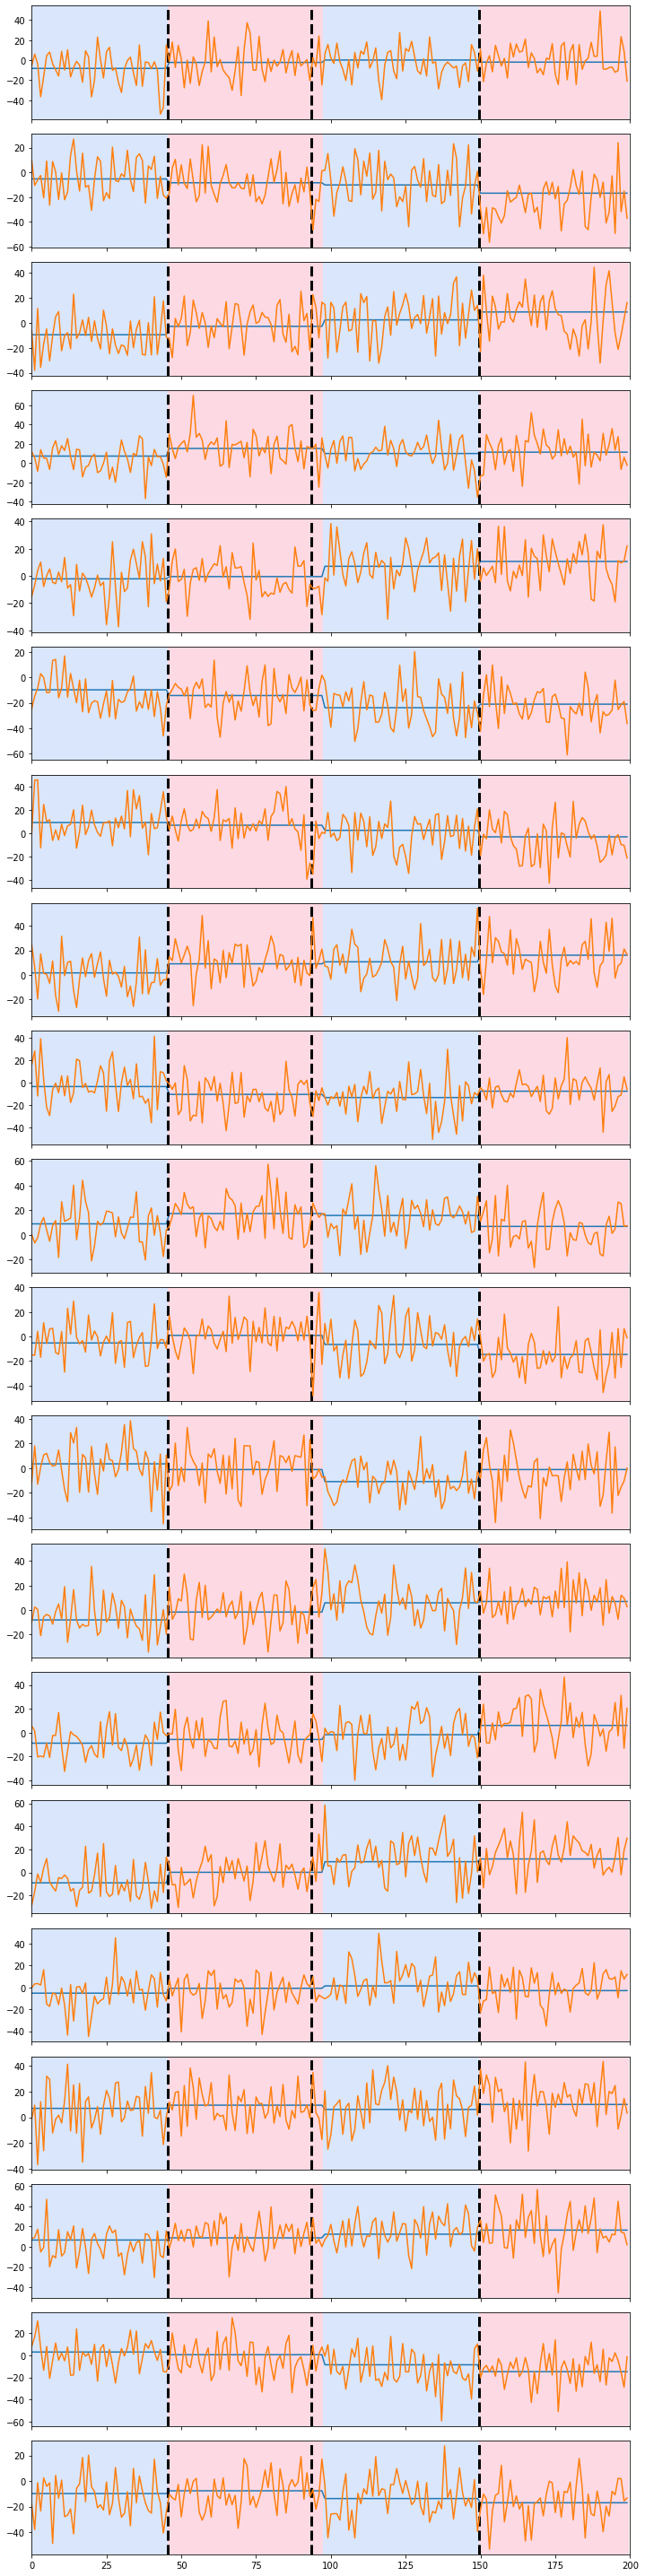

In [ ]:
predicted_bkps = algo.predict(n_bkps=n_bkps)

fig, ax_arr = rpt.display(signal, bkps, predicted_bkps)
for (signal1d_with_noise, ax) in zip(signal_with_noise.T, ax_arr):
    ax.plot(signal1d_with_noise)
    ax.set_xlim(0, n_samples)

print(f"error: {hausdorff(bkps, predicted_bkps)} samples")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Increase the dimension (you can turn off the display). What do you observe?</p>
</div>

Intuitively, a change is visible if $\|\delta\| / \|\epsilon\|$ is large where $\delta$ is the mean-shift amplitude and $\epsilon$ the noise.
A Gaussian vector has norm close to $\sqrt{d}\sigma$ and here $\|\delta\| = d$ where $d$ is the dimension.
This is the same reason why sphere volume / cube volume goes to zero when the dimension grows.

### Penalized change point detection (unknown $K$)

When the number of changes $K$, we can perform penalized detection:

$$
\min_{K, t_1,\dots,t_K} \left[ \left(\sum_k \sum_{t=t_k}^{t_{k+1}-1} \|y_t-\bar{y}_{t_k..t_{k+1}}\|^2 \right) + \beta K \right]
$$

when $\beta>0$ controls the trade-off between the data fidelity and the complexity of the segmentation.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>When the regularization parameter increases, do we detect more or less changes?</p>
</div>

This formulation generalizes a number of model selection criterion, for instance the well-known BIC criterion: $\beta_{\text{BIC}}=2\sigma^2\log(T)$ (where $T$ is the number of samples) for a univariate Gaussian process with piecewise constant mean and *known* variance.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>For a piecewise constant univariate signal with Gaussian noise, use BIC (with one and zero change) to asses the presence of a change.</p>
</div>

In [ ]:
signal, bkps = rpt.pw_constant(n_samples=n_samples, n_features=1, n_bkps=1, noise_std=1)

# use the already available cost function
cost = rpt.costs.CostL2().fit(signal)
cost.error(10, 20)  # cost on signal[10:20]

...

penalized_sum_of_cost_1_change = ... # sum of costs + beta * 1
penalized_sum_of_cost_0_change = ... # sum of costs + beta * 0

In [ ]:
print(f"BIC with one change: {penalized_sum_of_cost_1_change:.2f}")
print(f"BIC with zero change: {penalized_sum_of_cost_0_change:.2f}")

if penalized_sum_of_cost_0_change > penalized_sum_of_cost_1_change:
    print("There is one change.")
else:
    print("There is no change.")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Do the same with the pure noise signal.</p>
</div>

Let us apply the BIC criterion on a signal with several changes.

In [ ]:
# generate signal
n_samples = 1000
n_bkps = 5
n_dims = 1
noise_std = 1
signal, bkps = rpt.pw_constant(
    n_samples=n_samples, n_features=n_dims, n_bkps=n_bkps, noise_std=noise_std
)

Penalized change point detection is performed with PELT.

error: 0.0 samples


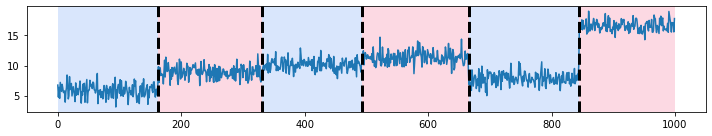

In [ ]:
pen_bic = 2 * np.log(n_samples) * noise_std**2
predicted_bkps = rpt.Pelt(model="l2", jump=1).fit_predict(
    signal=signal, pen=pen_bic
)

fig, ax_arr = rpt.display(signal, bkps, predicted_bkps)
print(f"error: {hausdorff(bkps, predicted_bkps)} samples")

## General distribution change (parametric)

By setting the cost function to the negative max log likelihood, we can detect any (parametric) distribution change.

$$
c(y_{a..b}) = -\max_\theta\log L(y_{a..b}, \theta)
$$

where $L(\cdot, \theta)$ is the likelihood of a distribution parametrized by $\theta$.

### Multivariate Gaussian

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Assume a multivariate Gaussian process with piecewise constant parameters (mean and covariance matrix). Derive the associated cost function and BIC penalty.</p>
</div>

$$
\min_{K, t_1,\dots,t_K} \left[ \left(\sum_k c(y_{t_k..t_{k+1}} \right) + \beta K \right]
$$

$$
-\max \ln L = \min_{K, t_1,\dots,t_K} \left(\sum_k c(y_{t_k..t_{k+1}} \right)
$$


$$
c(y_{a..b}) =  (b-a) \log \det \hat{\Sigma}_{a..b}
$$

$$
\beta_{BIC} = d(d+3)\log T
$$

### Count data (Poisson)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Assume a Poisson process with piecewise constant rate parameter. Derive the associated cost function and BIC penalty.</p>
</div>

$$\hat{\lambda} = \bar{y}_{a..b} $$


$$c(y_{a..b}) = 2 (b-a) \hat{\lambda} (1-\log\hat{\lambda})$$

$$\log T$$

We can define a cost function that can be used in `Dynp` and `Pelt`.

In [ ]:
class PoissonCost(BaseCost):

    """Custom cost for piecewise Poisson signals."""

    # The 2 following attributes must be specified for compatibility.
    model = "Poisson"
    min_size = 2

    def fit(self, signal):
        """Set the internal parameter."""
        self.signal = signal
        return self

    def error(self, start, end):
        """Return the approximation cost on the segment [start:end].

        Args:
            start (int): start of the segment
            end (int): end of the segment

        Returns:
            float: segment cost
        """
        sub = self.signal[start:end]
        lambda_hat = sub.mean() + 1e-10
        return 2 * lambda_hat * (end - start) * (1 - log(lambda_hat))

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Detect the change-points in the following signal (assume that the number of changes is unknown).</p>
</div>

In [ ]:
pwc_poisson_signal = np.array([16, 14, 9, 11, 10, 19, 7, 13, 18, 10, 15, 15, 6, 21, 15, 13, 15, 16, 14, 11, 11, 11, 16, 15, 10, 13, 5, 13, 11, 10, 17, 17, 14, 16, 9, 10, 9, 14, 14, 9, 4, 17, 10, 15, 19, 14, 18, 11, 11, 14, 11, 6, 15, 16, 15, 15, 12, 9, 16, 14, 12, 13, 10, 13, 19, 12, 14, 15, 16, 14, 10, 10, 13, 13, 17, 9, 9, 9, 16, 6, 7, 9, 11, 13, 23, 10, 9, 9, 18, 19, 15, 5, 14, 14, 7, 8, 22, 13, 13, 7, 14, 11, 8, 11, 18, 9, 9, 20, 10, 9, 14, 16, 9, 8, 8, 19, 14, 16, 9, 11, 15, 13, 14, 10, 14, 15, 15, 16, 9, 10, 6, 5, 12, 6, 10, 10, 5, 11, 13, 9, 9, 10, 11, 12, 14, 11, 9, 9, 11, 10, 7, 11, 6, 10, 13, 9, 5, 13, 13, 6, 8, 8, 6, 10, 14, 15, 8, 21, 10, 7, 12, 14, 11, 15, 11, 11, 13, 9, 11, 11, 14, 9, 10, 10, 9, 10, 9, 6, 8, 7, 12, 10, 15, 6, 8, 10, 9, 9, 17, 8, 9, 6, 5, 15, 3, 12, 10, 11, 11, 8, 7, 9, 9, 10, 11, 10, 8, 15, 9, 12, 5, 8, 13, 12, 9, 12, 5, 13, 13, 9, 13, 9, 9, 11, 11, 15, 12, 11, 6, 9, 9, 2, 8, 17, 13, 5, 13, 10, 6, 9, 14, 9, 13, 12, 10, 9, 15, 13, 18, 7, 10, 7, 15, 17, 10, 15, 19, 11, 10, 15, 16, 12, 13, 15, 11, 11, 7, 11, 9, 11, 8, 10, 11, 19, 14, 18, 12, 18, 13, 9, 13, 12, 7, 12, 11, 15, 10, 17, 14, 9, 16, 19, 11, 11, 21, 12, 13, 19, 12, 11, 15, 16, 11, 14, 17, 12, 17, 16, 13, 11, 7, 21, 16, 13, 11, 13, 9, 13, 6, 15, 21, 10, 17, 8, 14, 11, 12, 17, 11, 12, 8, 16, 20, 10, 6, 13, 11, 14, 7, 10, 9, 8, 9, 19, 16, 17, 10, 11, 14, 6, 12, 16, 12, 18, 11, 16, 12, 6, 16, 11, 18, 12, 14, 12, 16, 14, 16, 14, 14, 19, 6, 12, 10, 25, 11, 16, 17, 16, 12, 9, 14, 14, 10, 15, 12, 17, 13, 16, 17, 13, 9, 22, 25, 20, 16, 14, 20, 15, 16, 14, 21, 15, 11, 14, 18, 11, 17, 19, 10, 17, 17, 9, 18, 12, 10, 10, 10, 19, 15, 25, 13, 20, 22, 17, 14, 12, 11, 13, 23, 17, 18, 19, 19, 9, 8, 16, 16, 20, 21, 23, 16, 17, 15, 17, 9, 19, 12, 18, 21, 17, 15, 17, 18, 17, 19, 20, 18, 9, 9, 18, 17, 12, 16, 14, 20, 11, 16, 13, 19, 16, 14, 16, 15, 17, 15, 19, 11, 17, 17, 14, 13, 10, 14, 13, 17, 15, 14, 14, 16, 26])
bkps = [128, 252, 377, 500]

In [ ]:
detected_bkps = rpt.Pelt(custom_cost=PoissonCost()).fit(pwc_poisson_signal).predict(np.log(pwc_poisson_signal.shape[0]))

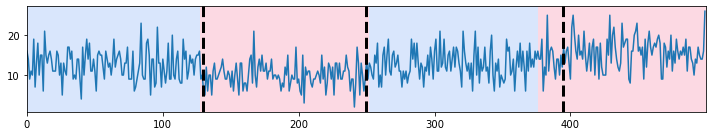

In [ ]:
fig, (ax,) = rpt.display(pwc_poisson_signal, bkps, detected_bkps)
ax.margins(x=0)

In [ ]:
print(detected_bkps)

[130, 250, 395, 500]


<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What are known limitations of the BIC criterion?</p>
</div>

$$BIC(M) = -2\ln \hat{L}(M) + k \log T$$

$$-2\ln\hat{L}(M) = \sigma^{-2}\sum_k c(y_{t_k..t_{k+1}})$$

$$k = K * 1$$

# Experiments

In [ ]:
dataset_name = "DodgerLoopGame"
data = load_uea_ucr_data(dataset_name)

indexes_with_nan = [7, 15, 19]
X_train = np.delete(data.X_train.data, indexes_with_nan, axis=0)
y_train = np.delete(data.y_train.data, indexes_with_nan, axis=0)

print(data.description)

# DodgersLoop dataset

The traffic data are collected with the loop sensor installed on ramp for the 101 North freeway in Los Angeles. This location is close to Dodgers Stadium; therefore the traffic is affected by volumne of visitors to the stadium.

We make three datasets out of these data.

## DodgersLoopDay

The classes are days of the week.

- Class 1: Sunday
- Class 2: Monday
- Class 3: Tuesday
- Class 4: Wednesday
- Class 5: Thursday 
- Class 6: Friday
- Class 7: Saturday 

Train size: 78

Test size: 80

Number of classes: 7

Missing value: Yes

Time series length: 288

Missing values are represented with NaN.

## DodgersLoopWeekend

- Class 1: Weekday
- Class 2: Weekend

Train size: 20

Test size: 138

Number of classes: 2

Missing value: Yes

Time series length: 288

Missing values are represented with NaN.

## DodgersLoopGame

- Class 1: Normal day
- Class 2: Game day

Train size: 20

Test size: 138

Number of classes: 2

Missing value: Yes

Time series length: 288

There is 

Plot the traffic on a normal day.

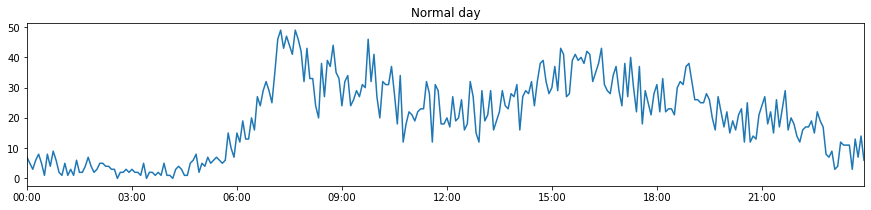

In [ ]:
ind = 8

signal = X_train[ind]
label = int(y_train[ind])

time_index = pd.date_range("00:00", "23:59", freq="5min")

fig, ax = fig_ax()
ax.plot(time_index, signal)
ax.xaxis.set_major_formatter(myFmt)
ax.margins(x=0)
_ = ax.set_title(f"{'Game day' if label==2 else 'Normal day'}")

## Change in the intensity of a Poisson distribution

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Detect changes in the Poisson rate parameter, with the BIC criterion.</p>
</div>

In [ ]:
detected_bkps =

In [ ]:
pen_bic = log(signal.shape[0])
detected_bkps = rpt.Pelt(custom_cost=PoissonCost(), jump=1).fit_predict(
    signal, pen=pen_bic
)

In [ ]:
detected_bkps

[11, 31, 56, 69, 79, 86, 95, 127, 163, 175, 208, 235, 274, 288]

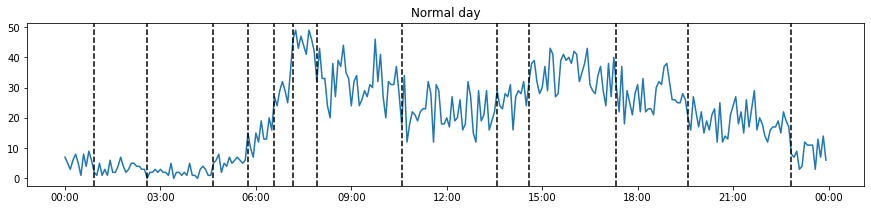

In [ ]:
fig, ax = fig_ax()
ax.plot(time_index, signal)

for b in detected_bkps[:-1]:
    ax.axvline(time_index[b], ls="--", color="k")

ax.xaxis.set_major_formatter(myFmt)
_ = ax.set_title(f"{'Game day' if label==2 else 'Normal day'}")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What do you observe?</p>
</div>

## Piecewise linear approximation

Instead we can use a piecewise linear approximation with continuity constraint (cost function `clinear`).

In [ ]:
data.location

PosixPath('/Users/charles/.loadmydata_datasets/DodgerLoopGame')

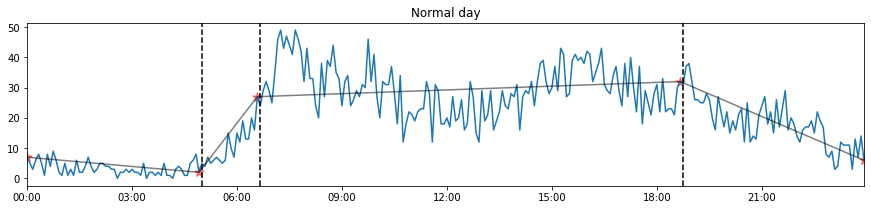

In [ ]:
fig, ax = fig_ax()

detected_bkps = rpt.Dynp(model="clinear").fit(signal).predict(n_bkps=3)
plot_clinear_approx(time_index=time_index, signal=signal, bkps=detected_bkps, ax=ax)
_ = ax.set_title(f"{'Game day' if label==2 else 'Normal day'}")

The associated BIC criterion is $\beta_{\text{clinear}, BIC} = 2\sigma^2\log(T)$.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>The PELT algorithm does not work with the continuous piecewise linear model. Code a function to compute the penalized segmentation with this model. You can assume that $K<K_{\max}=15$.</p>
    <p>Detect changes with the BIC criterion. (Use the first 50 samples to estimate the variance.)</p>

</div>

$$\min_{K, t_1,\dots,t_K} \left[ \left(\sum_{k=0}^K c(y_{t_k..t_{k+1}}) \right) + \beta K \right] = \min_{K=1,\dots,K_{\max}}  \beta K + \min_{t_1,\dots,t_K} \left[ \left(\sum_{k=0}^K c(y_{t_k..t_{k+1}}) \right)\right]$$













In [ ]:
K_max = 15

def pen_clinear(signal: np.ndarray, pen: float)->list:
    n_samples = signal.shape[0]
    algo = rpt.Dynp(model="clinear", jump=5).fit(signal)
    algo.predict(n_bkps=K_max)
    list_of_v = [algo.cost.sum_of_costs([n_samples])]
    for n_bkps in range(1, K_max):
        bkps = algo.predict(n_bkps=n_bkps)
        list_of_v.append(algo.cost.sum_of_costs(bkps) + pen * n_bkps)

    n_bkps_opt = np.argmin(list_of_v)
    if n_bkps_opt==0:
        return [n_samples]
    else:
        return algo.predict(n_bkps=n_bkps_opt)

In [ ]:
pen_bic = 2 * signal[:50].var() * log(signal.shape[0])
detected_bkps = pen_clinear(signal=signal, pen=pen_bic)

In [ ]:
print(detected_bkps)

[45, 65, 85, 90, 95, 100, 105, 135, 165, 190, 220, 225, 250, 260, 288]


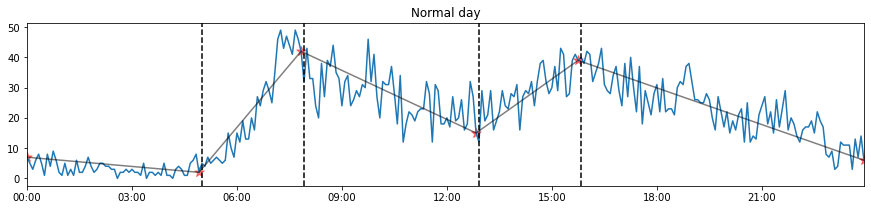

In [ ]:
fig, ax = fig_ax()
plot_clinear_approx(time_index=time_index, signal=signal, bkps=detected_bkps, ax=ax)
_ = ax.set_title(f"{'Game day' if label==2 else 'Normal day'}")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What do you think of this segmentation?</p>
</div>

## Supervised segmentation

To find a better regularization, we can use a few annotated examples.



I manually annotated four signals.

In [ ]:
# manually chosen
segmentation_labels = {0: [63, 97, 156, 187, 288],
                       2: [63, 184, 288],
                       10: [56, 93, 260, 270, 288],
                       11: [40, 170, 255, 271, 288]}

Look at the annotations.

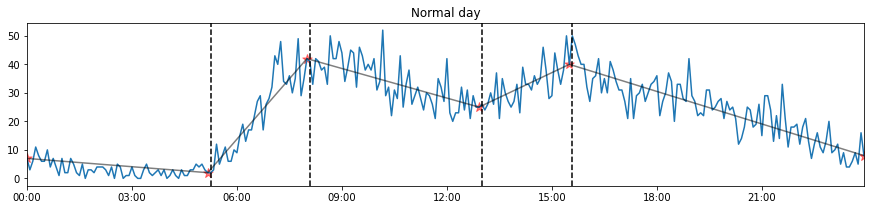

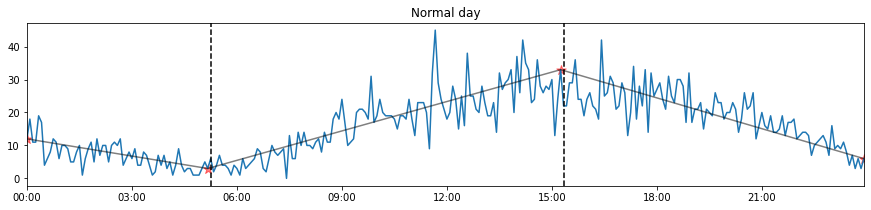

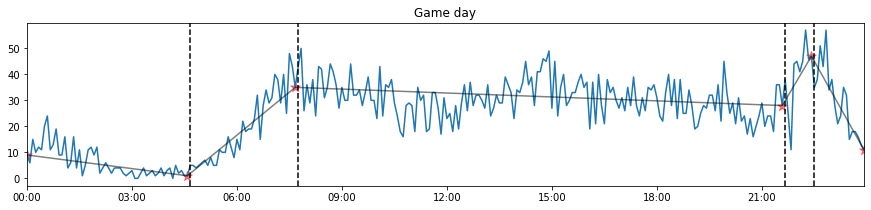

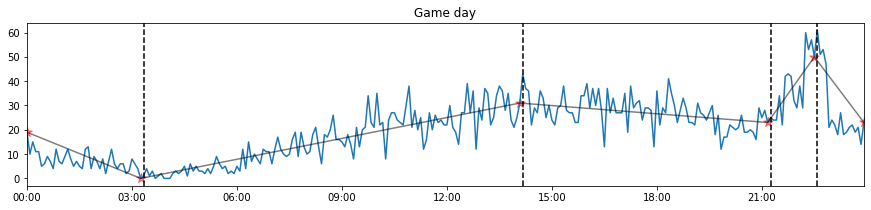

In [ ]:
for (signal_index, manual_segmentation) in segmentation_labels.items():
    fig, ax = fig_ax()
    signal = X_train[signal_index]
    label = int(y_train[signal_index])

    # plot
    plot_clinear_approx(time_index=time_index, signal=signal, bkps=manual_segmentation, ax=ax)
    _ = ax.set_title(f"{'Game day' if label==2 else 'Normal day'}")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Code the loss function.</p>
    <p>Find the optimal penalty value.</p>
</div>

In [ ]:
def loss_func(beta):
    loss_val = 0
    for (signal_index, manual_segmentation) in segmentation_labels.items():
        signal = X_train[signal_index]
        cost = rpt.costs.CostCLinear().fit(signal)
        detected_bkps = pen_clinear(signal=signal, pen=beta)
        n_bkps_manual = len(manual_segmentation) - 1
        n_bkps_detected = len(detected_bkps) - 1
        loss_val += cost.sum_of_costs(manual_segmentation) + beta * n_bkps_manual
        loss_val -= cost.sum_of_costs(detected_bkps) + beta * n_bkps_detected
    return loss_val

In [ ]:
opt = minimize(loss_func, x0=np.array([3000]))
print(opt)
pen_opt = opt.x[0]
pen_opt

/usr/local/Caskroom/miniconda/base/envs/tutorial-mva-1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


      fun: -2535.5067634699117
 hess_inv: array([[344.6625]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 16
      nit: 2
     njev: 8
   status: 0
  success: True
        x: array([1966.0125])


1966.0124999999998

In [ ]:
pen_bic

204.77718133009992

Compute the loss for the manual segmentation.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Using the supervised penalty value, segment all signals from the training set.</p>
    <p>Plot all piecewise linear approximations, for each class (Normal day or Game day) separately.</p>
</div>

In [ ]:
list_of_segmentations = list()
for signal in X_train:
    detected_bkps = pen_clinear(signal, pen=pen_opt)
    list_of_segmentations.append(detected_bkps)

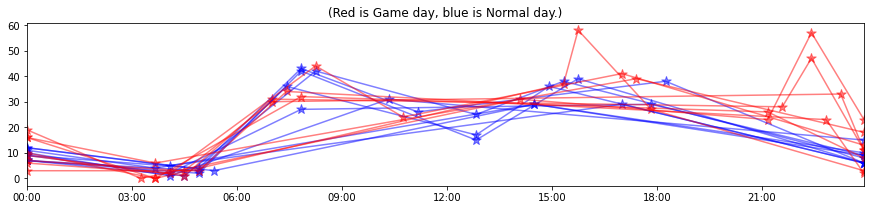

In [ ]:
fig, ax = fig_ax()

for (signal, label, detected_bkps) in zip(
    X_train, y_train, list_of_segmentations
):
    color = "b" if label == "1" else "r"
    indexes = np.r_[0, np.array(detected_bkps) - 1]
    ax.plot(
        np.take(time_index, indexes),
        np.take(signal, indexes),
        color=color,
        alpha=0.5,
    )
    ax.scatter(
        np.take(time_index, indexes),
        np.take(signal, indexes),
        color=color,
        alpha=0.5,
        s=100,
        marker="*",
    )
ax.set_title("(Red is Game day, blue is Normal day.)")
ax.margins(x=0)
ax.xaxis.set_major_formatter(myFmt)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>How would use the segmentations to classify the signals?</p>
</div>